<a href="https://colab.research.google.com/github/gabrielfraga17/IA-Generativa/blob/main/AKCIT_GenAI_M10_Colab_Unidade_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

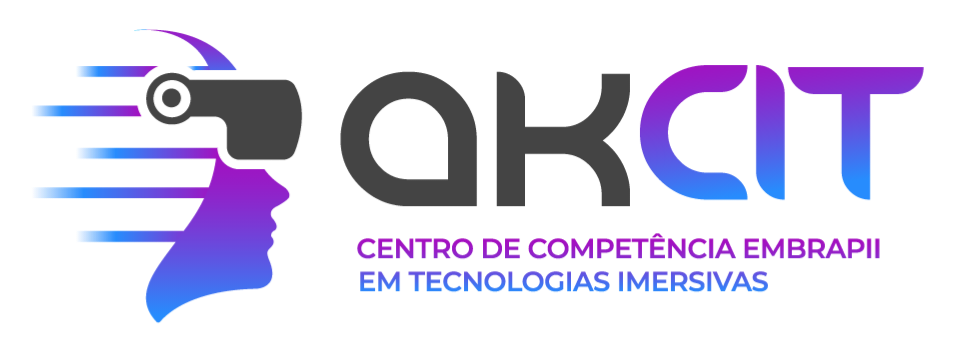


# Identificação

**Microcurso:** Arquiteturas neurais avançadas para IA generativa para visão computacional


**Docente:** M.Sc. Leon Sólon da Silva

## 🎯 Objetivos de Aprendizagem
Ao concluir esta unidade prática no Colab, você será capaz de:
- Entender como autoencoders aprendem representações comprimidas.  
- Implementar modelos de **autoencoder denso e convolucional**.  
- Explicar a diferença fundamental entre **AE** e **VAE**.  
- Explorar o espaço latente e realizar **interpolação de amostras**.  
- Utilizar VAEs para **gerar novas imagens plausíveis** a partir de distribuições latentes.  

## 📌 Tópico II – Autoencoders e VAEs
Nesta unidade, você terá contato direto com a implementação de **Autoencoders** e **Variational Autoencoders (VAEs)** em datasets de imagens.  
Primeiro, construiremos um **autoencoder simples**, depois um **convolucional**, e por fim ampliaremos a arquitetura para um **VAE**, explorando sua capacidade de reconstruir e gerar imagens novas.  
A cada etapa, exemplos de código, visualizações e desafios guiarão a consolidação da teoria na prática.

## 📖 Explicação Teórica
- **Autoencoder clássico**: composto por um encoder (compressão), um código latente (gargalo) e um decoder (reconstrução). Treinado para minimizar o erro de reconstrução entre entrada e saída.  
- **Espaço Latente**: representação comprimida e abstrata dos dados, onde apenas as características essenciais são mantidas. Útil para compressão, busca por similaridade e manipulação criativa.  
- **Autoencoder Convolucional**: utiliza convoluções no encoder/decoder para lidar com imagens, aproveitando padrões locais e reduzindo parâmetros. Produz reconstruções mais realistas que modelos densos.  
- **Variational Autoencoder (VAE)**: versão probabilística que impõe uma distribuição no espaço latente (geralmente Gaussiana). Permite amostrar vetores latentes e gerar novos dados coerentes.  
- **Função de perda do VAE**: combinação de erro de reconstrução (MSE ou cross-entropy) com regularização via **KL-Divergence**.  


## 💻 Exemplos Práticos
- Construção de um **autoencoder convolucional** aplicado a imagens (ex.: CIFAR-10 ou STL-10).  
- Visualização de **imagens originais vs. reconstruídas**.  
- Demonstração do **espaço latente** e interpolação entre representações.  
- Extensão para um **VAE simples**, mostrando geração de novas imagens a partir de amostras aleatórias.  

## Para executar o notebook

Esse notebook vai demorar muito a execução se você utilizar o ambiente de execução normal do Colab (CPU). Pra alterar clique na setinha ao lado de "RAM/DISCO" e selecione "Alterar o tipo de ambiente de execução". Selectio GPUs: T4


### 📦 Preparação do ambiente
Nesta primeira célula realizamos as **importações de bibliotecas essenciais** para o projeto:

- `numpy` e `matplotlib` para manipulação de arrays e visualização de imagens.  
- `tensorflow.keras` para construção do modelo de autoencoder.  
- `os`, `tarfile` e `requests` para lidar com o download e extração do dataset.  

Aqui estamos configurando o ambiente para receber e treinar um **autoencoder convolucional** com imagens maiores (96×96), do dataset **STL-10**.


In [ ]:
# ======================================================
# Autoencoder com STL-10 (96x96 colorido)
# ======================================================

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import tarfile
import requests

### 📂 Carregando o dataset STL-10
O **STL-10** é um conjunto de dados criado como versão em alta resolução do CIFAR-10:  
- Contém imagens de **96×96 pixels em RGB**.  
- Possui 10 classes (avião, pássaro, carro, gato, cachorro, etc.).  
- Muito usado para testar arquiteturas de **aprendizado não supervisionado**.  

Nesta célula:  
1. Fazemos o **download e extração** do STL-10 a partir do site oficial da Stanford.  
2. Definimos funções auxiliares para ler os arquivos binários (`read_all_images`).  
3. Normalizamos os valores de pixel para o intervalo `[0,1]`, o que facilita o treinamento da rede.  

Ao final, imprimimos o formato dos dados para confirmar que temos os conjuntos de treino e teste carregados corretamente.


In [ ]:
# ----------------------------
# 1. Baixar e carregar STL-10
# ----------------------------

url = "http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz"
data_dir = "stl10_data"

if not os.path.exists(data_dir):
    os.makedirs(data_dir, exist_ok=True)
    r = requests.get(url, stream=True)
    with open("stl10_binary.tar.gz", "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    tar = tarfile.open("stl10_binary.tar.gz", "r:gz")
    tar.extractall(path=data_dir)
    tar.close()

# Funções auxiliares para carregar os binários do STL-10
def read_all_images(path_to_data):
    with open(path_to_data, "rb") as f:
        everything = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(everything, (-1, 3, 96, 96))
        images = np.transpose(images, (0, 3, 2, 1))  # (num, 96, 96, 3)
        return images

def read_labels(path_to_labels):
    with open(path_to_labels, "rb") as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

x_train = read_all_images(os.path.join(data_dir, "stl10_binary/train_X.bin"))
x_test = read_all_images(os.path.join(data_dir, "stl10_binary/test_X.bin"))

# Normalizar
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("Train:", x_train.shape, "Test:", x_test.shape)

/tmp/ipython-input-2535103387.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=data_dir)


Train: (5000, 96, 96, 3) Test: (8000, 96, 96, 3)


### 🧠 Construção do Autoencoder
Nesta etapa definimos a **arquitetura da rede neural**:

- **Encoder**: reduz progressivamente a resolução da imagem (96×96 → 6×6), aumentando o número de filtros. Essa compressão força a rede a capturar apenas as características essenciais.  
- **Latent Space**: o gargalo (6×6×256) representa a versão comprimida da imagem.  
- **Decoder**: faz o processo inverso, reconstruindo a imagem a partir do espaço latente. Para isso usamos camadas **Conv2DTranspose**, também chamadas de *deconvoluções*, que aumentam a resolução.  

O resultado é um modelo que aprende a **compactar e depois reconstruir** as imagens do dataset.


In [ ]:

# ----------------------------
# 2. Criar o modelo Autoencoder
# ----------------------------



# Encoder
encoder_input = layers.Input(shape=(96, 96, 3)) # Lembram do RGB? 96 x 96 x 3 = 27.648 pixels
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(encoder_input) # 32 mapas de caracteristicas
x = layers.MaxPooling2D((2,2), padding="same")(x)  # 48x48 (redução de dimensionalidade com max pooling)
x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x) # 64 mapas de caracteristicas
x = layers.MaxPooling2D((2,2), padding="same")(x)  # 24x24 (redução de dimensionalidade com max pooling)
x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x) # 128 mapas de caracteristicas
x = layers.MaxPooling2D((2,2), padding="same")(x)  # 12x12 (redução de dimensionalidade com max pooling)
x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x) # 256 mapas de caracteristicas
latent = layers.MaxPooling2D((2,2), padding="same")(x)  # 6x6 (redução de dimensionalidade com max pooling)

encoder = models.Model(encoder_input, latent, name="encoder") # espaço latente 6x6x256 (ou seja, redução de 27.648 para 9.216)

# Decoder
decoder_input = layers.Input(shape=(6,6,256))
x = layers.Conv2DTranspose(256, (3,3), strides=2, activation="relu", padding="same")(decoder_input)  # 12x12
x = layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="same")(x)  # 24x24
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)  # 48x48
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)  # 96x96
decoder_output = layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(x)

decoder = models.Model(decoder_input, decoder_output, name="decoder")

# Autoencoder completo
autoencoder_input = encoder_input
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)

autoencoder = models.Model(autoencoder_input, decoded, name="autoencoder")

### ⚙️ Treinamento do Autoencoder
Agora compilamos e treinamos o modelo:

- **Otimizador:** Adam (ajusta os pesos da rede durante o treinamento).  
- **Função de perda:** MSE (*Mean Squared Error*), que mede a diferença entre a imagem original e a reconstruída.  

O treinamento é feito por **20 épocas** com batch size de **64 imagens**.  
O objetivo é minimizar o erro de reconstrução, de forma que o modelo aprenda a reconstruir imagens cada vez mais fiéis às originais.


In [ ]:
# ----------------------------
# 3. Compilar e treinar
# ----------------------------
autoencoder.compile(optimizer="adam", loss="mse")

history = autoencoder.fit(
    x_train, x_train,
    epochs=20,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 249ms/step - loss: 0.0619 - val_loss: 0.0226
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.0213 - val_loss: 0.0202
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0194 - val_loss: 0.0172
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0169 - val_loss: 0.0149
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.0143 - val_loss: 0.0127
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.0125 - val_loss: 0.0116
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.0099 - val_loss: 0.0103
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 12

### 🖼️ Visualização das reconstruções
Nesta célula avaliamos qualitativamente o desempenho do autoencoder:

- Selecionamos algumas imagens do conjunto de teste.  
- Passamos pelo modelo para obter suas **reconstruções**.  
- Plotamos lado a lado: **imagem original** vs. **imagem reconstruída**.  

Esse tipo de visualização é essencial para entender **o quanto o modelo conseguiu capturar da estrutura da imagem original**.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


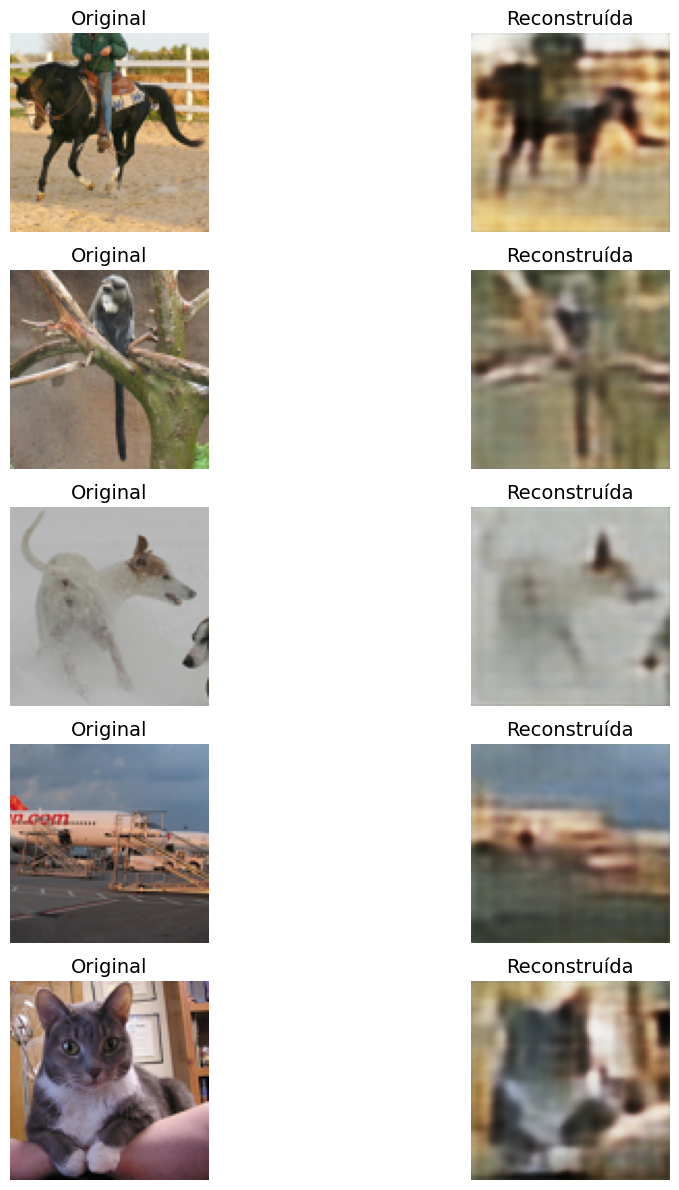

In [ ]:
# ----------------------------
# 4. Visualizar resultados
# ----------------------------
decoded_imgs = autoencoder.predict(x_test[:5])

n = 5
plt.figure(figsize=(12, 12))
for i in range(n):
    # Original
    ax = plt.subplot(n, 2, 2*i + 1)
    plt.imshow(x_test[i])
    plt.title("Original", fontsize=14)
    plt.axis("off")

    # Reconstruída
    ax = plt.subplot(n, 2, 2*i + 2)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstruída", fontsize=14)
    plt.axis("off")

plt.tight_layout()
plt.show()

### 🧩 O que é um Variational Autoencoder (VAE)?

O **VAE (Variational Autoencoder)** é uma extensão do Autoencoder clássico.  
A diferença principal é que o VAE aprende uma **distribuição latente** em vez de apenas um vetor fixo.  

- O encoder não gera diretamente o vetor latente `z`, mas sim **média (μ)** e **variância (σ²)**.  
- O espaço latente é **amostrado** dessa distribuição, garantindo mais diversidade.  
- A função de perda combina **erro de reconstrução** + **termo de regularização (KL Divergence)**.  

Assim, o VAE não apenas comprime e reconstrói os dados, mas também aprende uma representação **probabilística e generativa**.

Vamos treinar um **VAE convolucional** no **CIFAR-10**:
- Encoder/decoder com **Conv/ConvTranspose**;
- **Perda = BCEWithLogitsLoss (reconstrução)** + **KL Divergence**;
- Visualizações: **reconstruções**, **amostras do prior** e **interpolações no espaço latente**.

> Por que CIFAR-10? É leve, colorido e roda bem no Colab/GPU.

In [ ]:
# Se estiver no Colab recente, já vem com torch/torchvision.
# Descomente se quiser garantir versões:
# !pip install -q torch torchvision

import math, os, random, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Semente para reprodutibilidade
SEED = 42
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)


Device: cuda


In [ ]:
# Ajuste para ficar igual ao AE:
IMAGE_SIZE = 64   # use 32 se seu AE treinou em 32x32
BATCH_SIZE = 128
EPOCHS = 20
LR = 2e-3
LATENT_DIM = 6 * 6 * 256  # você pode alinhar com o AE se quiser
NUM_WORKERS = 2 if torch.cuda.is_available() else 0


In [ ]:
# STL-10 original é 96x96; vamos redimensionar para IMAGE_SIZE
# Obs: mantemos no intervalo [0,1] para BCE com Sigmoid
stl_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
])

root = "./data"

full_train = datasets.STL10(root=root, split="train", download=True, transform=stl_transform)
test_set   = datasets.STL10(root=root, split="test",  download=True, transform=stl_transform)

# (Opcional) separar uma validação pequena do train
val_ratio = 0.1
val_size = int(len(full_train) * val_ratio)
train_size = len(full_train) - val_size
train_set, val_set = random_split(full_train, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)} | Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")


100%|██████████| 2.64G/2.64G [01:02<00:00, 41.9MB/s]


Train: 4500 | Val: 500 | Test: 8000 | Image size: 64x64


In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=LATENT_DIM, img_size=IMAGE_SIZE):
        super().__init__()
        self.latent_dim = latent_dim
        self.img_size = img_size

        # ---------------------------
        # ENCODER
        # ---------------------------
        # Convoluções + downsampling (stride=2) reduzem resolução,
        # mas aumentam o número de canais (features).
        # Objetivo: extrair representações compactas da imagem.
        ch = 32
        self.encoder = nn.Sequential(
            # Downsample 1: dobra canais, reduz altura e largura
            # Entrada: (B, 3, H, W) → saída: (B, 32, H/2, W/2)
            nn.Conv2d(in_channels, ch, 3, stride=2, padding=1),
            nn.BatchNorm2d(ch),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample 2: dobra canais, reduz altura e largura
            # (B, 32, H/2, W/2) → (B, 64, H/4, W/4)
            nn.Conv2d(ch, ch*2, 3, stride=2, padding=1),
            nn.BatchNorm2d(ch*2),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample 3: dobra canais, reduz altura e largura
            # (B, 64, H/4, W/4) → (B, 128, H/8, W/8)
            nn.Conv2d(ch*2, ch*4, 3, stride=2, padding=1),
            nn.BatchNorm2d(ch*4),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample final
            # (B, 128, H/8, W/8) → (B, 256, H/16, W/16)
            nn.Conv2d(ch*4, ch*8, 3, stride=2, padding=1),
            nn.BatchNorm2d(ch*8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Descobre automaticamente (C, H, W) da saída do encoder
        self.enc_out_shape = self._get_enc_out_shape(in_channels, img_size)
        flat_dim = self.enc_out_shape[0] * self.enc_out_shape[1] * self.enc_out_shape[2]

        # Essas duas camadas lineares produzem os parâmetros da distribuição latente
        # μ (média) e log(σ²) (log-variância).
        # Cada imagem terá sua própria distribuição q(z|x).
        self.fc_mu = nn.Linear(flat_dim, latent_dim)      # gera μ
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)  # gera log σ²

        # ---------------------------
        # DECODER
        # ---------------------------
        # O decoder reconstrói a imagem a partir de uma amostra z ~ N(μ, σ²).
        # Primeiro projeta z em um "feature map" com shape igual ao final do encoder,
        # depois vai upsampling com ConvTranspose2d.
        self.dec_in = nn.Linear(latent_dim, flat_dim)
        self.decoder = nn.Sequential(
            # Upsample 1: dobra altura e largura, reduz canais
            nn.ConvTranspose2d(ch*8, ch*4, 4, stride=2, padding=1),
            nn.BatchNorm2d(ch*4),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample 2
            nn.ConvTranspose2d(ch*4, ch*2, 4, stride=2, padding=1),
            nn.BatchNorm2d(ch*2),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample 3
            nn.ConvTranspose2d(ch*2, ch, 4, stride=2, padding=1),
            nn.BatchNorm2d(ch),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample final → volta para 3 canais (RGB)
            nn.ConvTranspose2d(ch, in_channels, 4, stride=2, padding=1),
            nn.Sigmoid(),  # saída ∈ [0,1], ideal para BCE
        )

    def _get_enc_out_shape(self, in_channels, img_size):
        """Descobre a forma da saída do encoder testando com batch fictício."""
        with torch.no_grad():
            x = torch.zeros(1, in_channels, img_size, img_size)
            y = self.encoder(x)
        return y.shape[1], y.shape[2], y.shape[3]  # (C, H, W)

    def encode(self, x):
        """Extrai features, achata e gera μ e log σ² (parametros da distribuição q(z|x))."""
        h = self.encoder(x)              # (B,C,H,W)
        h = h.view(h.size(0), -1)        # flatten → (B, flat_dim)
        mu = self.fc_mu(h)               # vetor μ
        logvar = self.fc_logvar(h)       # vetor log σ²
        return mu, logvar

    def reparam(self, mu, logvar):
        """Truque da reparametrização:
        - Calcula σ = exp(0.5 * logvar)
        - Amostra eps ~ N(0,I)
        - Retorna z = μ + σ * eps
        """
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Reconstrói imagem a partir do vetor latente z."""
        h = self.dec_in(z)                       # projeta z → flat_dim
        C, H, W = self.enc_out_shape
        h = h.view(z.size(0), C, H, W)           # reshape para mapa de features
        x_hat = self.decoder(h)                  # aplica upsampling
        return x_hat

    def forward(self, x):
        """Fluxo completo:
        x → encoder → (μ, logσ²) → amostra z → decoder → reconstrução."""
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [ ]:
# Instancia modelo e mostra nº de parâmetros
model = ConvVAE().to(device)
sum_params = sum(p.numel() for p in model.parameters())/1e6
print(model.__class__.__name__, f"~{sum_params:.2f}M params")

ConvVAE ~114.35M params


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def vae_loss(x_hat, x, mu, logvar):
    # Reconstrução: BCE soma por pixel (mais estável p/ [0,1] + Sigmoid)
    recon = F.binary_cross_entropy(x_hat, x, reduction="sum")
    # KL divergência padrão (para N(0, I))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon + kl), recon, kl


In [ ]:
def train_epoch(loader):
    model.train()
    total, recon_total, kl_total = 0.0, 0.0, 0.0
    for x, _ in loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss, recon, kl = vae_loss(x_hat, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item()
        recon_total += recon.item()
        kl_total += kl.item()
    n = len(loader.dataset)
    return total / n, recon_total / n, kl_total / n

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    total, recon_total, kl_total = 0.0, 0.0, 0.0
    for x, _ in loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss, recon, kl = vae_loss(x_hat, x, mu, logvar)
        total += loss.item()
        recon_total += recon.item()
        kl_total += kl.item()
    n = len(loader.dataset)
    return total / n, recon_total / n, kl_total / n

history = []
best_val = math.inf
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_rec, tr_kl = train_epoch(train_loader)
    va_loss, va_rec, va_kl = eval_epoch(val_loader)

    history.append((epoch, tr_loss, va_loss))
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train={tr_loss:.2f} (rec={tr_rec:.2f} kl={tr_kl:.2f}) | "
          f"val={va_loss:.2f} (rec={va_rec:.2f} kl={va_kl:.2f})")

    # (Opcional) salvar melhor
    if va_loss < best_val:
        best_val = va_loss
        torch.save({"model": model.state_dict(),
                    "cfg": {"IMAGE_SIZE": IMAGE_SIZE, "LATENT_DIM": LATENT_DIM}},
                   "vae_stl10_best.pt")


[01/20] train=11167.86 (rec=8443.47 kl=2724.39) | val=8959.27 (rec=8601.40 kl=357.88)
[02/20] train=8341.11 (rec=8091.15 kl=249.96) | val=8333.78 (rec=7951.97 kl=381.81)
[03/20] train=8049.30 (rec=7804.95 kl=244.34) | val=7938.69 (rec=7680.24 kl=258.45)
[04/20] train=7874.72 (rec=7633.91 kl=240.81) | val=8352.96 (rec=8034.10 kl=318.85)
[05/20] train=7810.07 (rec=7563.65 kl=246.42) | val=7804.35 (rec=7563.02 kl=241.33)
[06/20] train=7709.84 (rec=7479.54 kl=230.31) | val=7625.37 (rec=7367.79 kl=257.59)
[07/20] train=7635.52 (rec=7414.83 kl=220.69) | val=7610.39 (rec=7359.00 kl=251.40)
[08/20] train=8747.33 (rec=7512.69 kl=1234.64) | val=288183.79 (rec=11305.88 kl=276877.90)
[09/20] train=8966.22 (rec=7999.00 kl=967.21) | val=9177.63 (rec=7947.70 kl=1229.94)
[10/20] train=8451.18 (rec=7757.96 kl=693.22) | val=9914.90 (rec=8420.35 kl=1494.55)
[11/20] train=8554.87 (rec=7724.02 kl=830.85) | val=9374.03 (rec=8139.54 kl=1234.49)
[12/20] train=8109.05 (rec=7584.55 kl=524.50) | val=8498.85 (rec

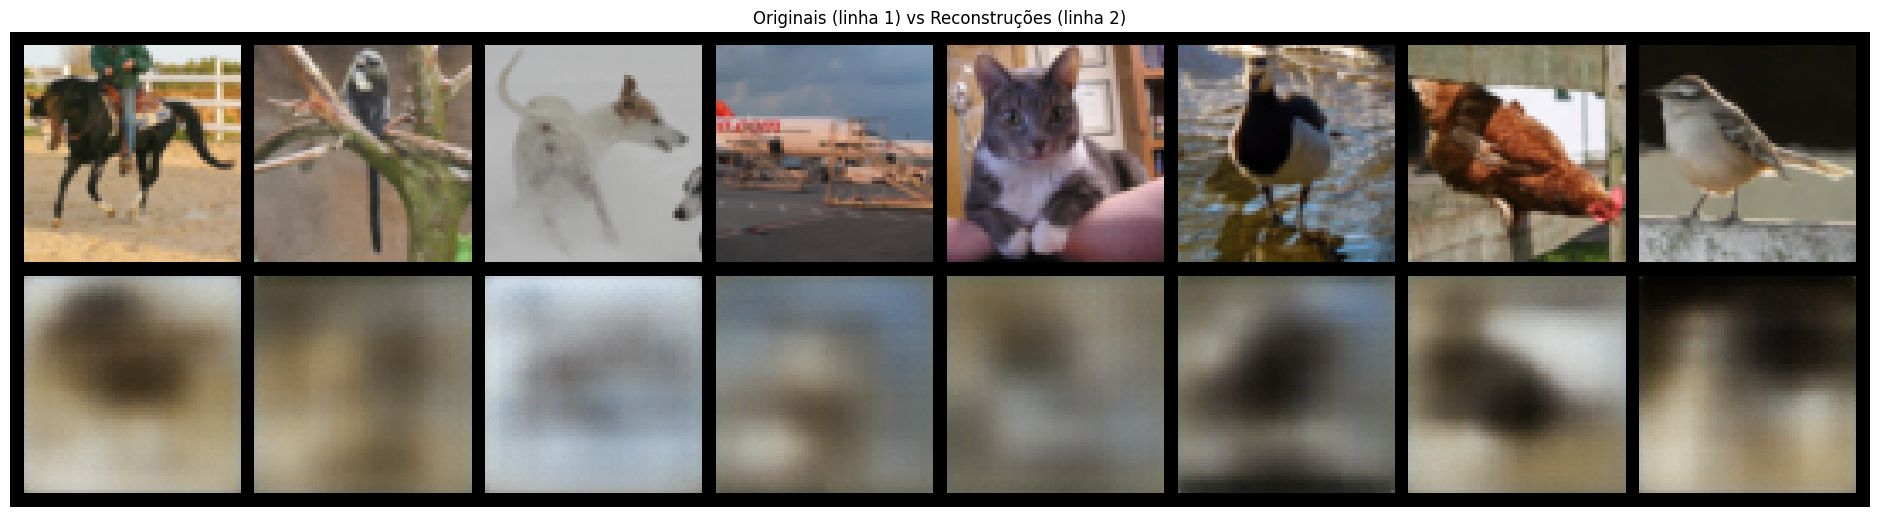

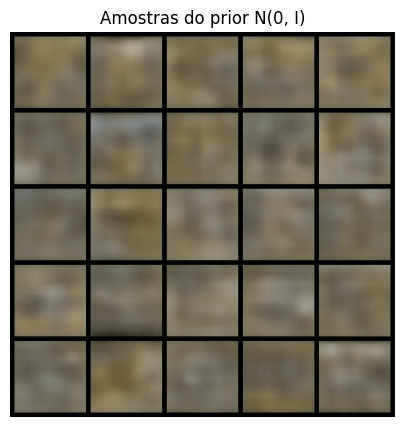

In [ ]:
@torch.no_grad()
def show_recon(loader, n=8, zoom=2.5):
    model.eval()
    x, _ = next(iter(loader))
    x = x[:n].to(device)
    x_hat, _, _ = model(x)

    # concatena originais + reconstruções
    grid = utils.make_grid(torch.cat([x, x_hat], dim=0), nrow=n, padding=4)

    # aumenta o figsize
    plt.figure(figsize=(n*zoom, 4*zoom))
    plt.axis("off")
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.title("Originais (linha 1) vs Reconstruções (linha 2)")


@torch.no_grad()
def sample_prior(n=16, zoom=2.0):
    model.eval()
    z = torch.randn(n, LATENT_DIM, device=device)
    x_hat = model.decode(z)
    side = int(math.sqrt(n))

    grid = utils.make_grid(x_hat, nrow=side, padding=4)

    plt.figure(figsize=(side*zoom, side*zoom))
    plt.axis("off")
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.title("Amostras do prior N(0, I)")


show_recon(test_loader, n=8, zoom=3.0)  # maior = mais grande
plt.show()

sample_prior(25, zoom=1)  # 25 = 5x5 grid
plt.show()


# 📝 Exercícios

## Exercício
**Objetivo:** Treinar o mesmo VAE no **Fashion-MNIST** (28×28 em tons de cinza).  
**Instruções:**
1. Troque o dataset para `torchvision.datasets.FashionMNIST` com `T.ToTensor()`.
2. Adapte o encoder/decoder para 1 canal (in/out = 1) e resoluções 28×28 (convs de 28→14→7).
3. Treine por 15–30 épocas e mostre reconstruções e amostras do prior.

## Desafio
**Objetivo:** Transformar este VAE em um **β-VAE** e avaliar o efeito da regularização no espaço latente.  
**Instruções:**
1. Adicione um argumento `beta` na função de perda e teste β ∈ {0.5, 1.0, 2.0, 4.0}.
2. Para cada β, treine 20–40 épocas e salve: curvas de perda, reconstruções, amostras e interpolações.
3. Compare visualmente: **mais β ⇒ latente mais “desentanglado”** (mas reconstruções podem piorar). Explique o trade-off.

> Extensão opcional: experimente `latent_dim ∈ {16, 32, 64, 128}` e discuta reconstrução vs. diversidade gerada.


## ✅ Conclusão
Neste notebook, implementamos e exploramos duas abordagens de **autoencoders** aplicadas a imagens:

- Um **autoencoder convolucional** treinado no dataset **STL-10**, capaz de comprimir imagens de 96×96 em um espaço latente e depois reconstruí-las.  
- Um **Variational Autoencoder (VAE)**, que além de reconstruir imagens, aprende uma **distribuição probabilística** no espaço latente, permitindo **gerar novas imagens**.

🔑 Pontos principais:
- Estruturação de **encoders** e **decoders** com convoluções.  
- Diferença entre **AE clássico** (compressão determinística) e **VAE** (modelagem de distribuição latente).  
- Avaliação qualitativa das reconstruções e amostras geradas.